# Esercitazione 9 

1. Confrontare le prestazioni (accuratezza) di
    + `GaussianNB`
    + `RidgeClassifier`
    + `Gaussian Mixture Models` \
      con e senza PCA. _(I modelli andranno a classificare gli esempi sullo spazio ottenuto da PCA.)_
2. Visualizzare i grafici ottenuti per tutti gli embedding su `sklearn`.
3. Confrontiamo anche in modo quantitativo il risultato in base all'accuracy.
+ Replicare tutte le analisi anche per un problema di regressione.

# Confronto di prestazioni tra modelli

## Carico il dataset `Wine`

In [1]:
from sklearn.datasets import load_wine
import numpy as np

In [2]:
wine = load_wine()
X, y = load_wine(return_X_y= True)

## Pipeline: Standard scaler + PCA 

In [3]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [4]:
pipeline = make_pipeline(StandardScaler(), PCA(n_components = 2))

X_transformed = pipeline.fit_transform(X)

display(f"Original shape: {X.shape}")
display(f"Transformed shape: {X_transformed.shape}")

'Original shape: (178, 13)'

'Transformed shape: (178, 2)'

### Plot PCA

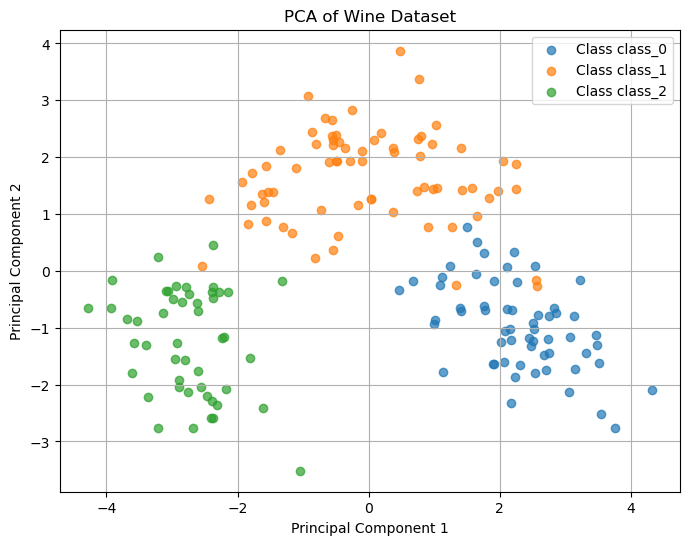

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

for target in np.unique(y):
    plt.scatter(X_transformed[y == target, 0], X_transformed[y == target, 1], 
                label=f'Class {wine.target_names[target]}', alpha=0.7)

plt.title("PCA of Wine Dataset")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)
plt.show()

## Simple k fold function for evaluation

In [6]:
from sklearn.model_selection import KFold, cross_val_score
import numpy as np

def evaluate_with_kfold(model, X, y, n_splits=5):
    if len(X) != len(y):
        print(f"Error: Mismatched lengths - X: {len(X)}, y: {len(y)}")
        return None

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    try:
        scores = cross_val_score(model, X, y, cv=kf, scoring='accuracy')
        mean_acc = np.mean(scores)
        std_acc = np.std(scores)
        print(f"Mean Accuracy: {mean_acc:.4f} ± {std_acc:.4f}")
        return mean_acc, std_acc
    except ValueError as e:
        print(f"Error during cross-validation: {e}")
        return None

## Gaussian Naive Bayes

In [7]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [8]:
gnb = GaussianNB()

In [9]:
display("Original X:")
evaluate_with_kfold(gnb, X, y)

display("Transformed X:")
evaluate_with_kfold(gnb, X_transformed, y)

'Original X:'

Mean Accuracy: 0.9830 ± 0.0228


'Transformed X:'

Mean Accuracy: 0.9719 ± 0.0176


(0.9719047619047618, 0.017572511115045146)

## Ridge classifier

In [10]:
from sklearn.linear_model import RidgeClassifier 

In [11]:
rc = RidgeClassifier(max_iter=500, random_state=42)

In [12]:
display("Original X:")
evaluate_with_kfold(rc, X, y)

display("Transformed X:")
evaluate_with_kfold(rc, X_transformed, y)

'Original X:'

Mean Accuracy: 1.0000 ± 0.0000


'Transformed X:'

Mean Accuracy: 0.9719 ± 0.0176


(0.9719047619047618, 0.017572511115045146)

## Random forest

In [13]:
from sklearn.ensemble import RandomForestClassifier

In [14]:
rf = RandomForestClassifier()

In [15]:
display("Original X:")
evaluate_with_kfold(rf, X, y)

display("Transformed X:")
evaluate_with_kfold(rf, X_transformed, y)

'Original X:'

Mean Accuracy: 0.9832 ± 0.0223


'Transformed X:'

Mean Accuracy: 0.9717 ± 0.0252


(0.9717460317460318, 0.025205629512735514)

## Gaussian Mixture Models

In [16]:
from sklearn.mixture import GaussianMixture

In [17]:
gm = GaussianMixture(n_components=2, random_state=42)

In [18]:
display("Original X:")
evaluate_with_kfold(rf, X, y)

display("Transformed X:")
evaluate_with_kfold(rf, X_transformed, y)

'Original X:'

Mean Accuracy: 0.9887 ± 0.0138


'Transformed X:'

Mean Accuracy: 0.9662 ± 0.0211


(0.9661904761904762, 0.021091409830949964)

# Pre-processing for manifolds `digits`

## Carico datasets `Digits`

In [19]:
from sklearn.datasets import load_digits

In [20]:
digits = load_digits()

X, y = load_digits(return_X_y= True)

## Scaling

In [21]:
from sklearn.preprocessing import StandardScaler

In [22]:
scaler = StandardScaler()

X_std = scaler.fit_transform(X)

## Hyperparameters function

In [23]:
from sklearn.metrics import silhouette_score, adjusted_mutual_info_score
from sklearn.model_selection import ParameterSampler
import numpy as np
import random

def best_manifold(X, y, model, param_grid, metric="ami", n_iter=3, 
                                          random_state=42):
    best_score = -np.inf
    best_params = None
    
    sampler = ParameterSampler(param_grid, n_iter=n_iter, random_state=random_state)

    for params in sampler:
        try:
            embedding = model(**params)
            X_embedded = embedding.fit_transform(X)

            if metric == "silhouette" and X_embedded.shape[1] == 2:
                score = silhouette_score(X_embedded, y)
            elif metric == "ami":
                score = adjusted_mutual_info_score(y, np.argmax(X_embedded, axis=1))
            else:
                continue
            
            print(f"Executing function--Params: {params} => {metric.upper()} Score: {score:.4f}")

            if score > best_score:
                best_score = score
                best_params = params

        except Exception as e:
            print(f"Error with params {params}: {e}")

    return {"Best Params": best_params, "Best Score": best_score}

## Fixing model to test

In [24]:
from sklearn.ensemble import RandomForestClassifier

In [25]:
model_rf = RandomForestClassifier()

# Exhaustive comparative analysis:

## Single t-SNE model

Tuning hyperparameters

In [26]:
from sklearn.manifold import TSNE

In [27]:
tsne_param_grid = {
    'n_components' : [2, 3],
    'perplexity': [10, 30],
    'learning_rate': [50, 100],
    'init': ['random', 'pca']
}

In [28]:
display("t-SNE Parameters (AMI):")
result = best_manifold(X_std, y, TSNE, tsne_param_grid, metric="ami", n_iter=2)

't-SNE Parameters (AMI):'

Executing function--Params: {'perplexity': 10, 'n_components': 2, 'learning_rate': 50, 'init': 'random'} => AMI Score: 0.2499
Executing function--Params: {'perplexity': 30, 'n_components': 2, 'learning_rate': 50, 'init': 'random'} => AMI Score: 0.2832


In [29]:
display("Now I show the best parameters")
best_tsne = result["Best Params"]
display(best_tsne)

'Now I show the best parameters'

{'perplexity': 30, 'n_components': 2, 'learning_rate': 50, 'init': 'random'}

In [30]:
X_embedded = TSNE(n_components = best_tsne['n_components'],
                  learning_rate = best_tsne['learning_rate'],
                  init = best_tsne['init'],
                  perplexity = best_tsne['perplexity']).fit_transform(X_std)

X_embedded.shape

(1797, 2)

In [31]:
display("Accuracy with transformed X:")
evaluate_with_kfold(model_rf, X_embedded, y)

'Accuracy with transformed X:'

Mean Accuracy: 0.9761 ± 0.0062


(0.9760755184153513, 0.006232869814175874)

In [32]:
print(f"Shape of X after transformation: {X_embedded.shape}")
print(f"Shape of y: {y.shape}")

Shape of X after transformation: (1797, 2)
Shape of y: (1797,)


### Visualize 

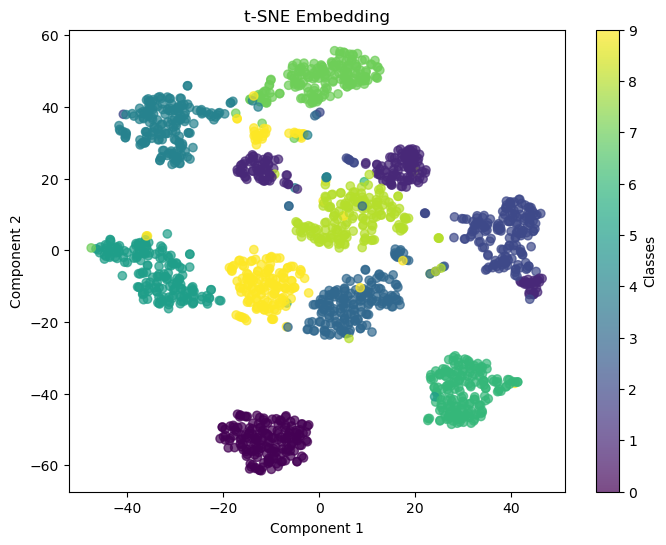

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y, cmap='viridis', alpha=0.7)
plt.title("t-SNE Embedding")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.colorbar(scatter, label="Classes")
plt.show()

## Altri modelli:
(supervisionati e non)
- [`sklearn.decomposition.TruncatedSVD`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html)
- [`sklearn.discriminant_analysis.LinearDiscriminantAnalysis`](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html)
- [`sklearn.ensemble import RandomTreesEmbedding`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomTreesEmbedding.html)
- [`sklearn.manifold.MDS`](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.MDS.html)
- [`sklearn.manifold.TSNE`](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)
- [`sklearn.manifold.Isomap`](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.Isomap.html)
- [`sklearn.manifold.LocallyLinearEmbedding`](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.LocallyLinearEmbedding.html)
- [`sklearn.manifold.SpectralEmbedding`](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.SpectralEmbedding.html)
- [`sklearn.neighbors.NeighborhoodComponentsAnalysis`](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.SpectralEmbedding.html) 
- [`sklearn.random_projection.SparseRandomProjection`](https://scikit-learn.org/stable/modules/generated/sklearn.random_projection.SparseRandomProjection.html)
- [`sklearn.random_projection.GaussianRandomProjection`](https://scikit-learn.org/stable/modules/generated/sklearn.random_projection.GaussianRandomProjection.html)

### Visualize embedding function 
We should use continuos values

In [34]:
def visualize_embedding(X_embedded, y, title):
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y, cmap='viridis', alpha=0.7)
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.colorbar(scatter, label='Target Value') 
    plt.show()

### Parameters grids

In [35]:
from sklearn.manifold import TSNE, MDS, Isomap, SpectralEmbedding, LocallyLinearEmbedding
from sklearn.random_projection import GaussianRandomProjection, SparseRandomProjection
from sklearn.decomposition import TruncatedSVD, KernelPCA
from sklearn.ensemble import RandomTreesEmbedding

models = {
    'TSNE': (TSNE, {
        'n_components': [2, 3],
        #'perplexity': [10, 30],
        #'learning_rate': [50, 100],
        #'init': ['random', 'pca']
    }),
    'MDS': (MDS, {
        'n_components': [2, 3],
       # 'metric': [True, False],
        'normalized_stress': [False]
    }),
    'Isomap': (Isomap, {
        'n_components': [2, 3],
        #'n_neighbors': [5, 10]
    }),
    'GaussianRandomProjection': (GaussianRandomProjection, {
        'n_components': [2, 3],
       # 'eps': [0.1, 0.5]
    }),
    'SparseRandomProjection': (SparseRandomProjection, {
        'n_components': [2, 3],
        #'density': [0.1, 0.5]
    }),
    'SpectralEmbedding': (SpectralEmbedding, {
        'n_components': [2, 3],
       # 'affinity': ['nearest_neighbors', 'rbf']
    }),
    'LocallyLinearEmbedding': (LocallyLinearEmbedding, {
        'n_components': [2, 3],
       # 'n_neighbors': [5, 10],
       # 'method': ['standard', 'modified']
    }),
    'RandomTreesEmbedding': (RandomTreesEmbedding, {
        'n_estimators': [10, 20],  
    }),
    'TruncatedSVD': (TruncatedSVD, {
        #'n_components': [2, 3]
    }),
    'KernelPCA': (KernelPCA, {
        'n_components': [2, 3],
       #'kernel': ['linear', 'rbf']
    })
}

Executing -- TSNE...
Executing function--Params: {'n_components': 3} => AMI Score: 0.4711
Mean Accuracy: 0.9755 ± 0.0041


'TSNE Accuracy: 0.9755 ± 0.0041'

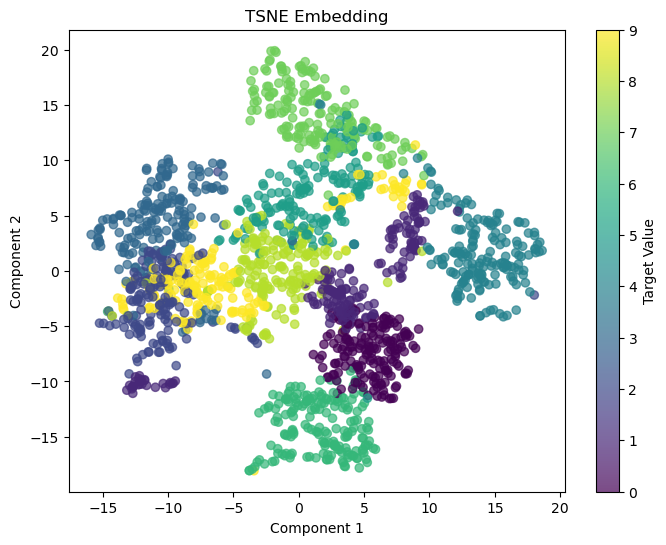

Executing -- MDS...
Executing function--Params: {'normalized_stress': False, 'n_components': 3} => AMI Score: 0.2572
Mean Accuracy: 0.7791 ± 0.0136


'MDS Accuracy: 0.7791 ± 0.0136'

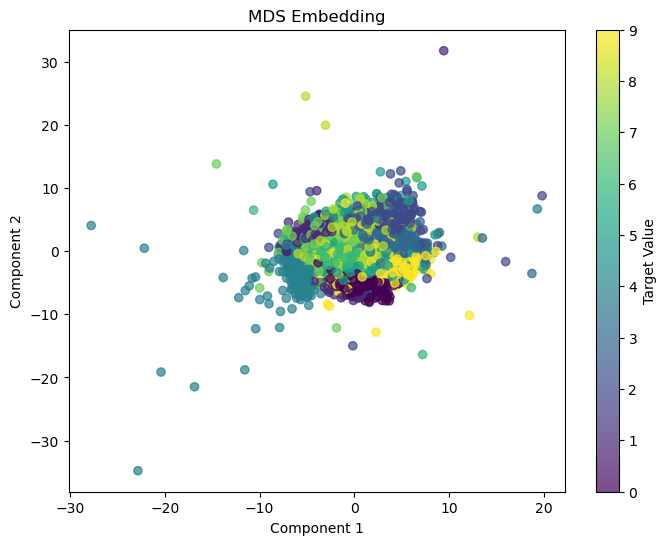

Executing -- Isomap...
Executing function--Params: {'n_components': 3} => AMI Score: 0.4088
Mean Accuracy: 0.9366 ± 0.0060


'Isomap Accuracy: 0.9366 ± 0.0060'

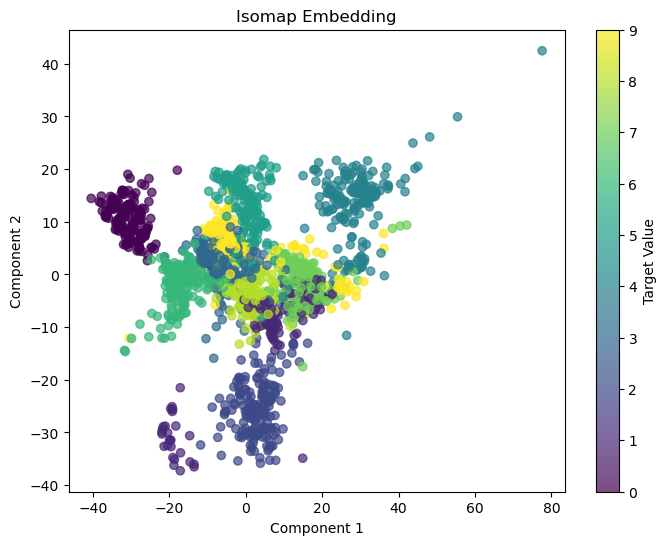

Executing -- GaussianRandomProjection...
Executing function--Params: {'n_components': 3} => AMI Score: 0.1371
Mean Accuracy: 0.4446 ± 0.0350


'GaussianRandomProjection Accuracy: 0.4446 ± 0.0350'

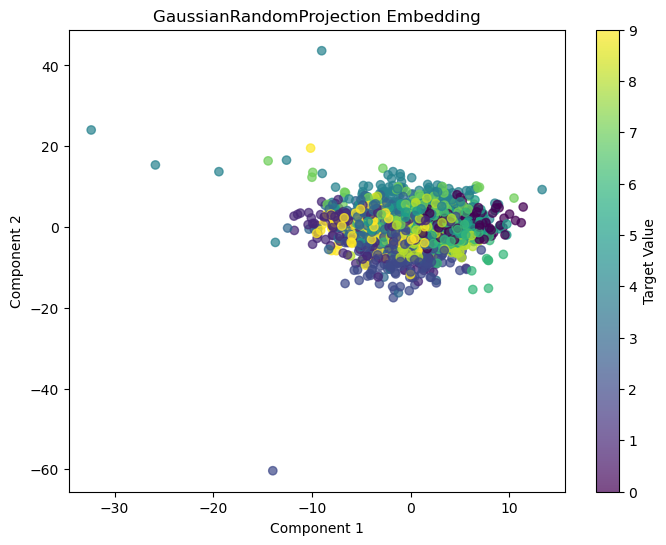

Executing -- SparseRandomProjection...
Executing function--Params: {'n_components': 3} => AMI Score: 0.1442
Mean Accuracy: 0.3623 ± 0.0156


'SparseRandomProjection Accuracy: 0.3623 ± 0.0156'

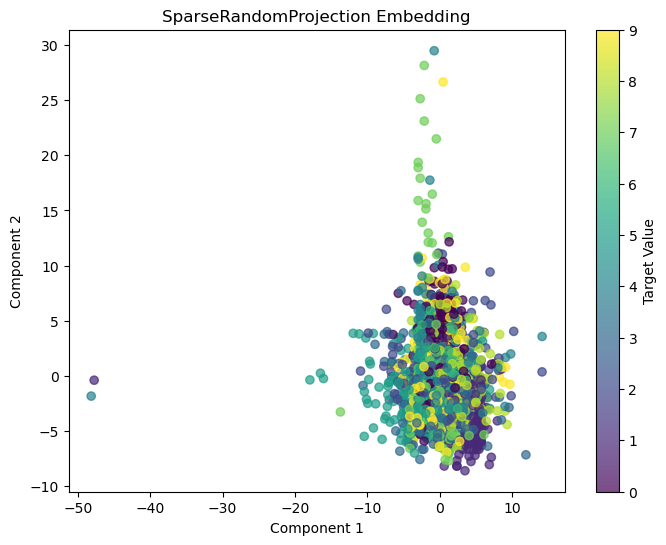

Executing -- SpectralEmbedding...
Executing function--Params: {'n_components': 3} => AMI Score: 0.3834
Mean Accuracy: 0.8180 ± 0.0194


'SpectralEmbedding Accuracy: 0.8180 ± 0.0194'

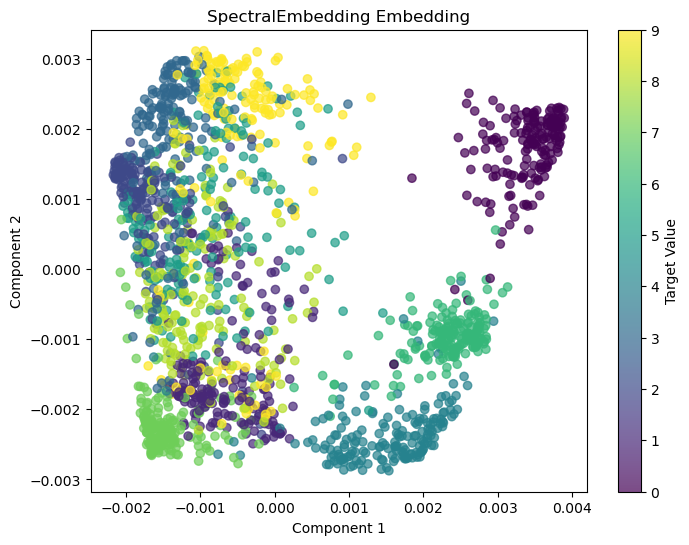

Executing -- LocallyLinearEmbedding...
Executing function--Params: {'n_components': 3} => AMI Score: 0.3015
Mean Accuracy: 0.8926 ± 0.0184


'LocallyLinearEmbedding Accuracy: 0.8926 ± 0.0184'

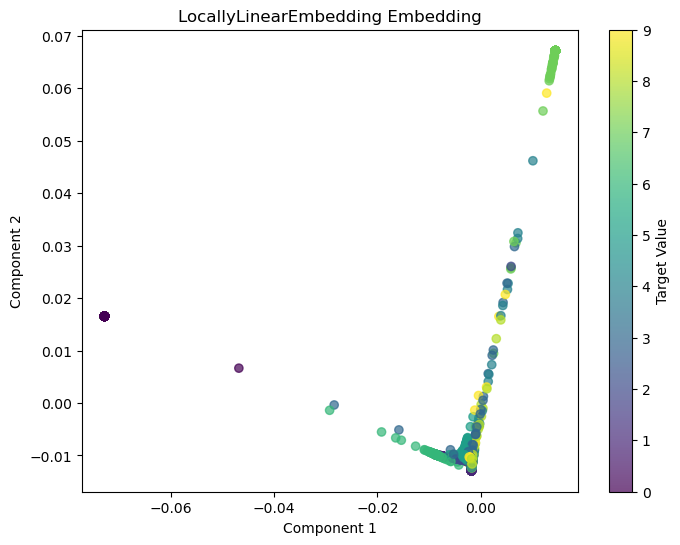

Executing -- RandomTreesEmbedding...
Error with params {'n_estimators': 20}: np.matrix is not supported. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
No valid parameters found for RandomTreesEmbedding, skipping...
Executing -- TruncatedSVD...
Executing function--Params: {} => AMI Score: 0.2477
Mean Accuracy: 0.5414 ± 0.0219


'TruncatedSVD Accuracy: 0.5414 ± 0.0219'

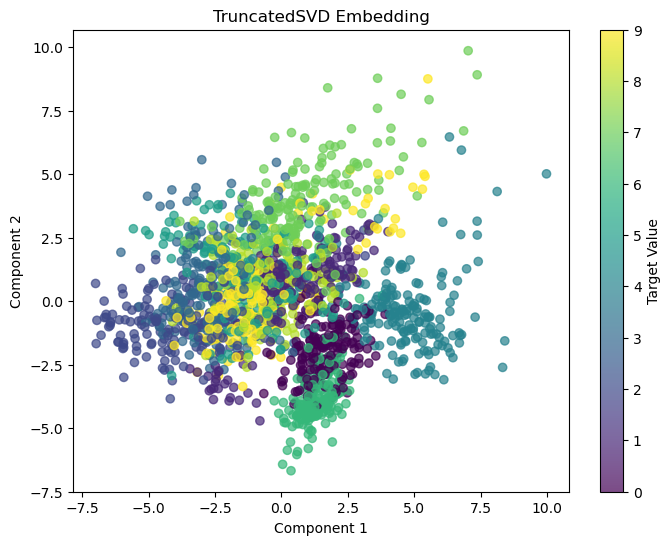

Executing -- KernelPCA...
Executing function--Params: {'n_components': 3} => AMI Score: 0.3126
Mean Accuracy: 0.7390 ± 0.0252


'KernelPCA Accuracy: 0.7390 ± 0.0252'

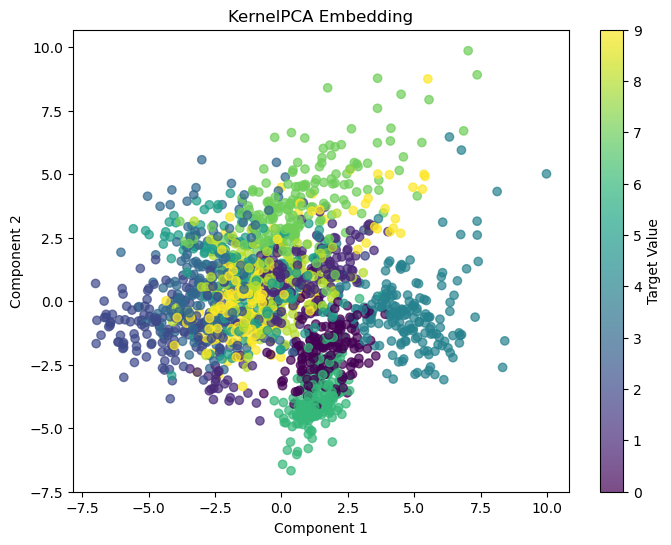

In [36]:
results = []

for model_name, (model, param_grid) in models.items():
    print(f"Executing -- {model_name}...")
    
    best = best_manifold(X_std, y, model, param_grid, n_iter= 1)
    best_params = best['Best Params']

    if best_params is None:
        print(f"No valid parameters found for {model_name}, skipping...")
        continue  # per finire il loop
    
    X_embedded = model(**best_params).fit_transform(X_std)
    
    accuracy, std_dev = evaluate_with_kfold(model_rf, X_embedded, y)
    results.append((model_name, accuracy, std_dev, best_params)) 

    display(f"{model_name} Accuracy: {accuracy:.4f} ± {std_dev:.4f}")
    visualize_embedding(X_embedded, y, f"{model_name} Embedding")

### Ranking methods

In [37]:
results.sort(key=lambda x: x[1], reverse=True)
print("Models ranked by accuracy:")
for model_name, accuracy, std_dev, params in results:
    print(f"{model_name}: {accuracy:.4f} ± {std_dev:.4f} - Params: {params}")

Models ranked by accuracy:
TSNE: 0.9755 ± 0.0041 - Params: {'n_components': 3}
Isomap: 0.9366 ± 0.0060 - Params: {'n_components': 3}
LocallyLinearEmbedding: 0.8926 ± 0.0184 - Params: {'n_components': 3}
SpectralEmbedding: 0.8180 ± 0.0194 - Params: {'n_components': 3}
MDS: 0.7791 ± 0.0136 - Params: {'normalized_stress': False, 'n_components': 3}
KernelPCA: 0.7390 ± 0.0252 - Params: {'n_components': 3}
TruncatedSVD: 0.5414 ± 0.0219 - Params: {}
GaussianRandomProjection: 0.4446 ± 0.0350 - Params: {'n_components': 3}
SparseRandomProjection: 0.3623 ± 0.0156 - Params: {'n_components': 3}


# Extra: 

## Prova con feature selection
Lavoriamo con `wine dataset`

In [38]:
from sklearn.datasets import load_wine

wine = load_wine()
X, y = load_wine(return_X_y= True)

In [39]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

In [40]:
X_new = SelectKBest(f_classif, k=2).fit_transform(X, y)

In [41]:
X_new.shape[0]

178

In [42]:
from sklearn.naive_bayes import GaussianNB

In [43]:
gnb = GaussianNB()

In [44]:
display("Original X:")
evaluate_with_kfold(gnb, X, y)

display("Transformed X:")
evaluate_with_kfold(gnb, X_new, y)

'Original X:'

Mean Accuracy: 0.9830 ± 0.0228


'Transformed X:'

Mean Accuracy: 0.9156 ± 0.0256


(0.9155555555555555, 0.025582653483054968)

## Autoencoders

Implementation of Autoencoders

We've created an autoencoder comprising two Dense layers: an encoder responsible for condensing the images into a 64-dimensional latent vector and a decoder tasked with reconstructing the initial image based on this latent space.

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [46]:
import tensorflow
print(tensorflow.__file__)
from tensorflow import keras

C:\Users\rubin\anaconda3\Lib\site-packages\tensorflow\__init__.py


In [47]:
from tensorflow import keras
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from keras.datasets import mnist

ModuleNotFoundError: No module named 'tensorflow.keras'

In [4]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

 2301952/11490434 [=====>........................] - ETA: 23s

KeyboardInterrupt: 

In [ ]:
class SimpleAutoencoder(Model):
    def __init__(self, latent_dimensions):
        super(SimpleAutoencoder, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(28, 28, 1)),
            layers.Flatten(),
            layers.Dense(latent_dimensions, activation='relu'),
        ])
        
        self.decoder = tf.keras.Sequential([
            layers.Dense(28 * 28, activation='sigmoid'),
            layers.Reshape((28, 28, 1))
        ])
    
    def call(self, input_data):
        encoded = self.encoder(input_data)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
latent_dimensions = 64
autoencoder = SimpleAutoencoder(latent_dimensions)
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

autoencoder.fit(x_train, x_train,
                epochs=10,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

In [ ]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

n = 6
plt.figure(figsize=(12, 6))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')

plt.show()